In [34]:
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

# Load data into memory
data = pd.read_csv('data.csv')
data = np.array(data)
print(data.shape)


(42000, 785)


In [35]:
X = data[:, 1:]
X = X.T
Y = data[:, 0]

d, N = X.shape

# Find the corresponding indeces
I1 = (Y==0)
I2 = (Y==6)
I3 = (Y==9)

# Split X and Y into X1, X2, X3 and Y1, Y2, Y3
X1 = X[:, I1]
X2 = X[:, I2]
X3 = X[:, I3]

Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]


In [36]:
def lda(X1,X2,X3,Y1,Y2,Y3):
    X = np.concatenate((X1, X2, X3), axis=1)
    Y = np.concatenate((Y1, Y2, Y3))
    # Within-clusters centroid
    C1 = np.mean(X1, axis=1)
    C2 = np.mean(X2, axis=1)
    C3 = np.mean(X3, axis=1)

    # Global centroid
    C = np.mean(X, axis=1)
    # Center each cluster dataset
    X1c = X1 - C1.reshape((d, 1))
    X2c = X2 - C2.reshape((d, 1))
    X3c = X3 - C3.reshape((d, 1))

    # Compute the within-cluster matrix by concatenation
    Xw = np.concatenate((X1c, X2c, X3c), axis=1)

    # Compute the within-cluster scatter matrix
    Sw = Xw @ Xw.T

    # Compute the Xbars
    Xbar1 = np.repeat(C1.reshape(d, 1), X1.shape[1], axis=1)
    Xbar2 = np.repeat(C2.reshape(d, 1), X2.shape[1], axis=1)
    Xbar3 = np.repeat(C3.reshape(d, 1), X3.shape[1], axis=1)

    # Compute the between-cluster dataset
    Xbar = np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)

    # Compute the between-cluster centered dataset
    Xbarc = Xbar - C.reshape((d, 1))

    # Compute the between-cluster scatter matrix
    Sb = Xbarc @ Xbarc.T
    # We want to compute the Cholesky decomposition of Sw
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        Sw = Sw + epsilon * np.eye(Sw.shape[0])

        L = np.linalg.cholesky(Sw)
    
    # Compute the first k eigenvector decomposition of L^-1 Sb L
    # _, W2 = np.linalg.eig(np.linalg.inv(L) @ Sb @ L)
    U, s, V = np.linalg.svd(np.linalg.inv(L) @ Sb @ L)
    W2 = np.real(U[:,:2])

    # Compute Q
    Q = np.linalg.inv(L).T @ W2
    Z = Q.T @ X
    return (Z, Q)

In [37]:
def split_data(X, Y, Ntrain):
    d, N = X.shape
    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]
    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

# Test it


Xoriginal = X
Yoriginal = Y
X = np.concatenate((X1, X2, X3), axis = 1)
Y = np.concatenate((Y1, Y2, Y3))
n_points = int(len(Y) * 5 / 10)
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, n_points)

I1 = (Y==0)
I2 = (Y==6)
I3 = (Y==9)
X1 = X[:,I1]
X2 = X[:,I2]
X3 = X[:,I3]

Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]

I1_train = (Ytrain==0)
I2_train = (Ytrain==6)
I3_train = (Ytrain==9)
X1_train = Xtrain[:,I1_train]
X2_train = Xtrain[:,I2_train]
X3_train = Xtrain[:,I3_train]

Y1_train = Ytrain[I1_train]
Y2_train = Ytrain[I2_train]
Y3_train = Ytrain[I3_train]

I1_test = (Ytest==0)
I2_test = (Ytest==6)
I3_test = (Ytest==9)
X1_test = Xtest[:,I1_test]
X2_test = Xtest[:,I2_test]
X3_test = Xtest[:,I3_test]

Y1_test = Ytest[I1_test]
Y2_test = Ytest[I2_test]
Y3_test = Ytest[I3_test]

In [38]:
lda_train , Q_train = lda(X1_train,X2_train,X3_train,Y1_train,Y2_train,Y3_train)
lda_test, Q_test = lda(X1_test,X2_test,X3_test,Y1_test,Y2_test,Y3_test)

In [39]:
lda_test = Q_train.T @ np.concatenate((X1_test,X2_test,X3_test), axis = 1)
#X1_test[:,0]

In [40]:
def classification(x, centroids, digits):
    distances = []
    for i in range(0, len(centroids)):
        distances.append(np.linalg.norm(x - centroids[i]))
    min_distance = min(distances)
    for i in range(0, len(distances)):
        if min_distance == distances[i]: return digits[i]
    return -1

def accuracy(Xs, Ys, centroids, digits):
    ok = []
    for i in range(0, len(Ys)):
        y = Ys[i]
        res = classification(Xs[:,i], centroids, digits)
        if y == res:
            ok.append(i)
    return len(ok) / len(Ys) * 100

In [47]:
#Y1_train,Y2_train,Y3_train
startX2Train = Y1_train.shape[0]
startX3Train = Y1_train.shape[0] + Y2_train.shape[0]

X1TrainLda = lda_train[:, : Y1_train.shape[0]]
X2TrainLda = lda_train[:,startX2Train : startX2Train + Y2_train.shape[0]]
X3TrainLda = lda_train[:,startX3Train:]


centroid_x1 = np.mean(X1TrainLda, axis = 1)
centroid_x2 = np.mean(X2TrainLda, axis = 1)
centroid_x3 = np.mean(X3TrainLda, axis = 1)


print(accuracy(lda_test, np.concatenate((Y1_train,Y2_train,Y3_train)), (centroid_x1, centroid_x2, centroid_x3), (0,6,9)))

97.14193962748877


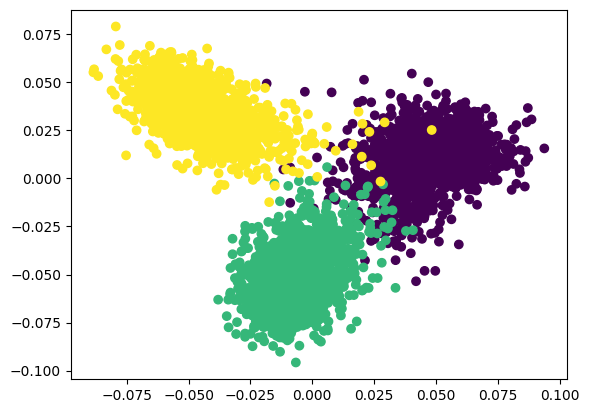

In [42]:
plt.scatter(lda_train[0,:], lda_train[1,:], c = np.concatenate((Y1_train, Y2_train, Y3_train)))
plt.show()

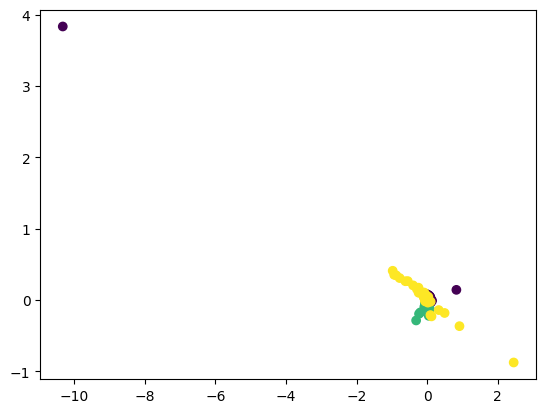

In [45]:
plt.scatter(lda_test[0,:], lda_test[1,:], c = np.concatenate((Y1_test, Y2_test, Y3_test)))
plt.show()